## Objective:

**To apply KMeans clustering on Amazon Food Reviews**

KMeans is one of the simplest clustering algorithms available. It is an unsupervised learning method. It's also very fast as compared to other clustering methods.

In this notebook, I'll apply KMeans to amazon food reviews represented in various vector formats like -

* Bag of Words (BoW)
* Term frequency inverse document frequency (Tfidf)
* Avg. Word to Vector (W2V)
* Tfidf weighted W2V

For each vector type, I'll plot the elbow curve, i.e. the graph of K (#clusters) vs the loss value. The loss function is shown in the picture below.

I'll also fetch a few sample reviews belonging to each cluster. I'll however not visualize the clusters through a graph, because as you will see ahead, the number of dimensions for each data point is HUGE! reducing them to 2-3 for visualization will result in significant loss of information, which will seriously limit the clustering capabilities of our model.

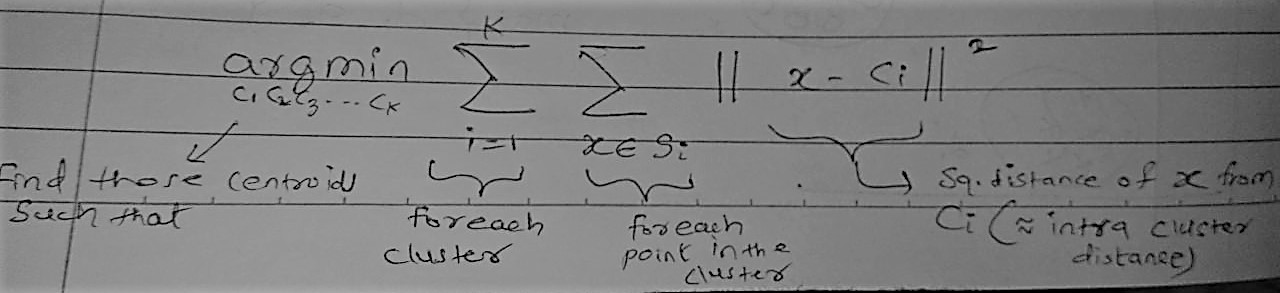

In [1]:
from IPython.display import Image
Image(r'C:\Users\ucanr\Dropbox\AAIC\assignments mandatory\10. Kmeans, HC, DBSCAN\loss function.jpg')

Let's begin by importing the necessary libraries

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.sparse import vstack
from sklearn.model_selection import GridSearchCV
import sqlite3

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

Let's define a couple of functions

* plot_elbow_curve
* get_cluster_samples: Using the predictions returned by the KMeans model, this fetches 'n' sample reviews belonging to each cluster

In [3]:
def plot_elbow_curve(df, vector_type):
    """
        Plot the k(n_clusters) vs loss.
        The definition of the loss function can be found in the image above.
        This loss is provided by KMeans in sklearn through an attribute called "inertia_"
    """
    plt.figure(figsize=(15,6))
    plt.style.use('bmh')
    sbn.lineplot(data=df, x='k',y='loss')
    plt.margins(0.02)
    plt.xlabel('n_clusters(K)')
    plt.ylabel('Loss')
    plt.title('{} | Elbow Curve - K vs Loss'.format(vector_type))
    plt.yscale('linear')

In [4]:
def get_cluster_samples(prediction_array, df_reviews_clean, n):
    """
        Recieve predicted cluster of all reviews for a certain value of K
        and return n sample reviews of each cluster type
    """
    samples = []

    for cluster_no in np.unique(prediction_array):

        ix = np.where(prediction_array == cluster_no)
        
        samples.append(df_reviews_clean.iloc[ix].head(n))
    
    for cluster_no in np.unique(prediction_array):
        print('-'*120)
        print('\nReviews in cluster: {}\n'.format(cluster_no))
        for review in list(samples[cluster_no]['Text']):
            print(review, end='\n\n')
    
    
    return samples

Load the original Text reviews stored on the disk. We'll need them to collect samples belonging to each cluster 

In [6]:
con = sqlite3.connect('/home/ucanreachtvk/data/reviews_cleaned_final.sqlite')
df_reviews_clean = pd.read_sql('select Text from Reviews;', con)

In [7]:
len(df_reviews_clean)

364171

## Bag of Words

Apply KMeans on BoW. Since this is an unsupervised learning method, we have no use for target variable 'y' and separate train/test sets. Therefore, we'll combine the train and test datasets and apply KMeans on the full data.

Same goes for other vector types too.

In [8]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_bow_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_bow_full_nparray.pkl', 'rb')
X_train_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_bow is : {}'.format(type(X_train_transformed_bow)))
print('The shape of X_train_transformed_bow is : {}'.format(X_train_transformed_bow.shape))

The datatype of X_train_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_bow is : (291336, 64221)


In [9]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_bow_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_bow_full_nparray.pkl', 'rb')
X_test_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_bow is : {}'.format(type(X_test_transformed_bow)))
print('The shape of X_test_transformed_bow is : {}'.format(X_test_transformed_bow.shape))

The datatype of X_test_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_test_transformed_bow is : (72835, 64221)


Combine the train and test data using **vstack**.

In [10]:
X_transformed_bow = vstack([X_train_transformed_bow, X_test_transformed_bow])

All 364k reviews

In [11]:
X_transformed_bow.shape

(364171, 64221)

**Rescale data**

In [ ]:
scaler = StandardScaler(with_mean=False)
X_transformed_bow_std = scaler.fit_transform(X_transformed_bow)

**Run KMeans on BoW**

Let's fit a kmeans model for each of the 'k' values given in the list below. The **fit_predict** function creates clusters in the data and also predicts to which cluster each data point belongs. This prediction for each k is captured in the list predictions. Specify n_jobs to take advantage of multiple cpu cores.

In [13]:
%%notify
%%time

dict_k_vs_loss = {'k':[], 'loss':[]}

predictions = []

for k in [2,3,4,5,6,7,8]:
    kmeans = KMeans(n_clusters=k, n_jobs=2)
    predictions.append(kmeans.fit_predict(X_transformed_bow_std))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    print('done k:= {} '.format(k))

done k:= 2 
done k:= 3 
done k:= 4 
done k:= 5 
done k:= 6 
done k:= 7 
done k:= 8 
CPU times: user 46min 15s, sys: 51.7 s, total: 47min 7s
Wall time: 1h 34min 57s


<IPython.core.display.Javascript object>

Convert the dictionary into a Pandas dataframe to create a lineplot from it using Seaborn.

In [14]:
df_k_vs_loss= pd.DataFrame(dict_k_vs_loss)

**Elbow curve | BoW**

Plot elbow curve to see the loss for each value of K

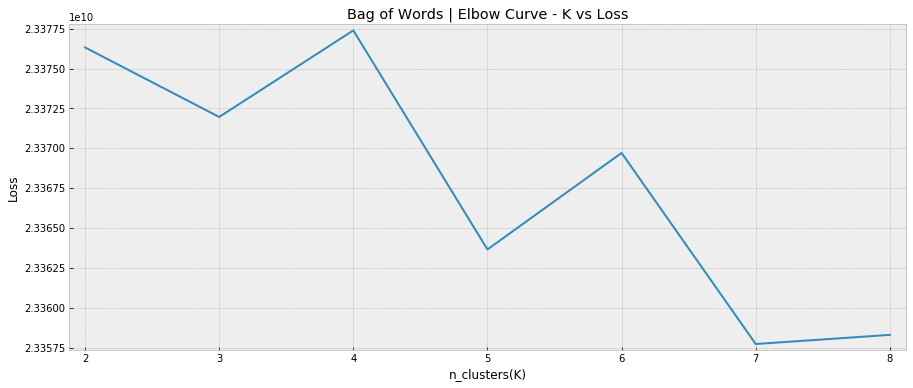

In [16]:
plot_elbow_curve(df_k_vs_loss, vector_type='Bag of Words')

Ideally, we'd like our cluster to have only two distinct clusters - positive reviews and negative reviews. But as can be seen in the graph above, the loss for  k=2 is the highest. For KMeans, this curve will keep its downword trend as K increases. We have to stop somewhere. Let's choose k=5 for further analysis.

### Sample reviews

For K = 5, our reviews have been divided into 5 clusters. The predicted cluster number for each review has been stored in the list 'prediction' I defined above. Predictions for the 5th cluster are at prediction[3] since 5 is stored at index 3
in the list through which k is iterating to fit KMeans.

Let's get 2 sample reviews from each cluster. Note that there can be clusters which have < n reviews in it.

In [17]:
_ = get_cluster_samples(predictions[3], df_reviews_clean, n=2)

------------------------------------------------------------------------------------------------------------------------

Reviews in cluster: 0

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

------------------------------------------------------------------------------------------------------------------------

Reviews in cluster: 1

I like this product. The price is right and it tastes good. I've got a self grinding coffee pot and this works well in it. I only have to clean out the grinding area after 1/2lbs. of beans have gone through. I do put half of the 5lb. bag into a gallon f

## Tfidf

Let's perform the same analysis, this time on Tfidf. Start by loading the train-test data stored on disk and combining them into a single set.

In [18]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_tfidf_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_tfidf_full_nparray.pkl', 'rb')
X_train_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_tfidf is : {}'.format(type(X_train_transformed_tfidf)))
print('The shape of X_train_transformed_tfidf is : {}'.format(X_train_transformed_tfidf.shape))

The datatype of X_train_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_tfidf is : (291336, 64221)


In [19]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_tfidf_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_tfidf_full_nparray.pkl', 'rb')
X_test_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_tfidf is : {}'.format(type(X_test_transformed_tfidf)))
print('The shape of X_test_transformed_tfidf is : {}'.format(X_test_transformed_tfidf.shape))

The datatype of X_test_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_test_transformed_tfidf is : (72835, 64221)


In [20]:
X_transformed_tfidf = vstack([X_train_transformed_tfidf, X_test_transformed_tfidf])
X_transformed_tfidf.shape

(364171, 64221)

In [21]:
type(X_transformed_tfidf)

scipy.sparse.csr.csr_matrix

**Rescale data**

In [23]:
scaler = StandardScaler(with_mean=False)
X_transformed_tfidf_std = scaler.fit_transform(X_transformed_tfidf)

**Run KMeans on Tfidf**

In [24]:
%%notify
%%time

dict_k_vs_loss = {'k':[], 'loss':[]}

predictions = []

for k in [2,3,4,5,6,7,8]:
    kmeans = KMeans(n_clusters=k, n_jobs = 2)
    predictions.append(kmeans.fit_predict(X_transformed_tfidf_std))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    print('done k:= {} '.format(k))

done k:= 2 
done k:= 3 
done k:= 4 
done k:= 5 
done k:= 6 
done k:= 7 
done k:= 8 
CPU times: user 1h 3min 9s, sys: 55.6 s, total: 1h 4min 4s
Wall time: 2h 23min 26s


<IPython.core.display.Javascript object>

In [25]:
df_k_vs_loss= pd.DataFrame(dict_k_vs_loss)

**Elbow curve | Tfidf** 

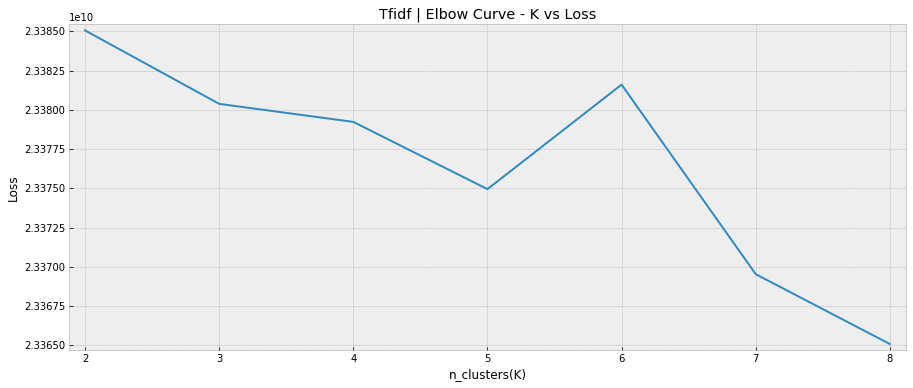

In [26]:
plot_elbow_curve(df_k_vs_loss, vector_type='Tfidf')

**Sample Reviews**

Let's get sample reviews belonging to clusters generated using k=5

In [27]:
_ = get_cluster_samples(predictions[3], df_reviews_clean, n=2)

------------------------------------------------------------------------------------------------------------------------

Reviews in cluster: 0

I have an 18 month old who only has 4 teeth. Needless to say, she still eats a lot of pureed foods. She can eat cereal, which she usually has for breakfast with fruit, however she's gotten bored with it. I got her some of these Earth's Best Oatmeals, which adds some variety to her breakfasts. She seems to like it a lot. I heat it up for 20 seconds in the microwave to make it warm oatmeal. I like the fact that this oatmeal has a lot of iron in it, which is necessary for a growing toddler!!

------------------------------------------------------------------------------------------------------------------------

Reviews in cluster: 1

One of my cats is allergic to fish and beef. This formula is one of the few she can eat, and it has much better ingredients than the prescription diets available at the vet. Both of my kitties are very active, have 

## Avg W2V

Apply KMeans on W2V data. Start by combining the train-test datasets.

In [28]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_avgW2V is : {}'.format(type(X_train_transformed_avgW2V)))
print('The shape of X_train_transformed_avgW2V is : {}'.format(X_train_transformed_avgW2V.shape))

The datatype of X_train_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_avgW2V is : (291336, 50)


In [29]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_avgW2V is : {}'.format(type(X_test_transformed_avgW2V)))
print('The shape of X_test_transformed_avgW2V is : {}'.format(X_test_transformed_avgW2V.shape))

The datatype of X_test_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_test_transformed_avgW2V is : (72835, 50)


In [30]:
X_transformed_w2v = np.vstack([X_train_transformed_avgW2V, X_test_transformed_avgW2V])
X_transformed_w2v.shape

(364171, 50)

In [32]:
type(X_transformed_w2v)

numpy.ndarray

**Rescale data**

In [34]:
scaler = StandardScaler(with_mean=True)
X_transformed_w2v_std = scaler.fit_transform(X_transformed_w2v)

**Run KMeans on Avg. W2V**

In [35]:
%%notify
%%time

dict_k_vs_loss = {'k':[], 'loss':[]}

predictions = []

for k in [2,3,4,5,6,7,8]:
    kmeans = KMeans(n_clusters=k, n_jobs=8)
    predictions.append(kmeans.fit_predict(X_transformed_w2v_std))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    print('done k:= {}'.format(k))

done k:= 2
done k:= 3
done k:= 4
done k:= 5
done k:= 6
done k:= 7
done k:= 8
CPU times: user 23min 59s, sys: 37 s, total: 24min 36s
Wall time: 6min 9s


<IPython.core.display.Javascript object>

In [36]:
df_k_vs_loss= pd.DataFrame(dict_k_vs_loss)

**Elbow curve | Avg. W2V**

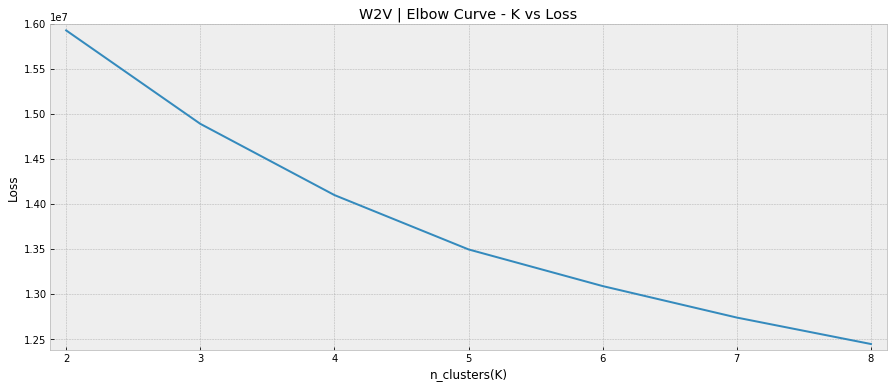

In [37]:
plot_elbow_curve(df_k_vs_loss, vector_type='W2V')

**Sample Reviews**

Fetch reviews from clusters generated using k=5

In [38]:
_ = get_cluster_samples(predictions[3], df_reviews_clean, n=2)

------------------------------------------------------------------------------------------------------------------------

Reviews in cluster: 0

I bought these for my husband who is currently overseas. He loves these, and apparently his staff likes them also.<br />There are generous amounts of Twizzlers in each 16-ounce bag, and this was well worth the price. <a href="http://www.amazon.com/gp/product/B001GVISJM">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>

I WAS VISITING MY FRIEND NATE THE OTHER MORNING FOR COFFEE , HE CAME OUT OF HIS STORAGE ROOM WITH ( A PACKET OF McCANNS INSTANT IRISH OATMEAL .) HE SUGGESTED THAT I TRY IT FOR MY OWN USE ,IN MY STASH . SOMETIMES NATE DOSE NOT GIVE YOU A CHANCE TO SAY NO , SO I ENDED UP TRYING THE APPLE AND CINN . FOUND IT TO BE VERY TASTEFULL WHEN MADE WITH WATER OR POWDERED MILK . IT GOES GOOD WITH O.J. AND COFFEE AND A SLICE OF TOAST AND YOUR READY TO TAKE ON THE WORLD...OR THE DAY AT LEAST..  JERRY REITH...

------------------------------

## Tfidf wt. W2V

Begin by combining train and test datasets.

In [39]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_TfidfW2V is : {}'.format(type(X_train_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_train_transformed_TfidfW2V.shape))

The datatype of X_train_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (291336, 50)


In [40]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_TfidfW2V is : {}'.format(type(X_test_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_test_transformed_TfidfW2V.shape))

The datatype of X_test_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (72835, 50)


In [41]:
X_transformed_tfidfw2v = np.vstack([X_train_transformed_TfidfW2V, X_test_transformed_TfidfW2V])
X_transformed_tfidfw2v.shape

(364171, 50)

**Rescale Data**

In [43]:
scaler = StandardScaler(with_mean=True)
X_transformed_tfidfw2v_std = scaler.fit_transform(X_transformed_tfidfw2v)

**Run KMeans on Tfidf wt. W2V**

In [44]:
%%notify
%%time

dict_k_vs_loss = {'k':[], 'loss':[]}

predictions = []

for k in [2,3,4,5,6,7,8]:
    kmeans = KMeans(n_clusters=k, n_jobs=8)
    predictions.append(kmeans.fit_predict(X_transformed_tfidfw2v_std))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    print('done k:= {}'.format(k))

done k:= 2
done k:= 3
done k:= 4
done k:= 5
done k:= 6
done k:= 7
done k:= 8
CPU times: user 13min 21s, sys: 25 s, total: 13min 46s
Wall time: 3min 27s


<IPython.core.display.Javascript object>

In [45]:
df_k_vs_loss= pd.DataFrame(dict_k_vs_loss)

**Elbow curve | Tfidf wt. W2V**

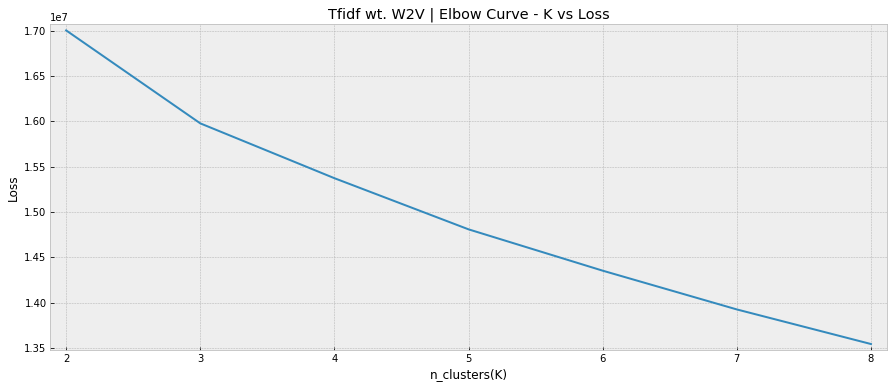

In [46]:
plot_elbow_curve(df_k_vs_loss, vector_type='Tfidf wt. W2V')

**Sample Reviews**

Fetch reviews belonging to clusters created using k=4.

In [47]:
_ = get_cluster_samples(predictions[2], df_reviews_clean, n=2)

------------------------------------------------------------------------------------------------------------------------

Reviews in cluster: 0

These looked like a perfect snack to through in with my trail mix.  Unfortunately, they arrived in a solid mass of melted chocolate.  I left them in my pantry for a few days, and when I opened them at room temperature they were still gooey.  I through them in the fridge and I've been breaking off hunks ever since.  They taste good to me, but the chocolate is all grainy after melting and then solidifying again.  I won't order them online again, but if I see them in a store I would pick them up.

I fed this to my Golden Retriever and he hated it.  He wouldn't eat it, and when he did, it gave him terrible diarrhea.  We will not be buying this again.  It's also super expensive.

------------------------------------------------------------------------------------------------------------------------

Reviews in cluster: 1

I have bought several of t

## Conclusion:

* Applied KMeans clustering on Amazon Food Reviews for various vector formats
* Analysed how the elbow curve behaves for Kmeans
* Fetched sample reviews belonging to each cluster